# 🧠🤖 Introdução ao Pytorch

O objetivo da aula de hoje é demonstrar como utilizar a biblioteca pytorch para treinar redes neurais. No processo, vamos estudar alguns conceitos como:
- Conjuntos de Validação (Validation Sets)
- O Algoritmo de Descida do Gradiente Estocástico (Stochastic Gradient Descent) e uso de Batches de Treinamento
- O uso do gráfico de perda para avaliar subajuste (underfitting) e superajuste (overfitting).
- A Entropia Cruzada (Cross Entropy) como Função de Perda em Problemas de Classificação 

## Preparação

Instalação do pytorch:

In [1]:
!python -m pip install torch torchvision

Imports utilizados no notebook:

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

sns.set_style('darkgrid')


## Fundamentos Teóricos 

### Underfitting, Overfitting e Regularização 


- Subajuste (**Underfitting**) - ocorre quando um modelo estatístico não capta adequadamente a estrutura subjacente dos dados. Pode acontecer por falta de uma quantidade suficiente de parâmetros no modelo ou treinamento por uma quantidade insuficiente de épocas.

- Sobreajuste (**Overfitting**) - ocorre quando um modelo estatístico contém mais parâmetros do que os dados justificam e é treinado por mais tempo que o necessário para alcançar um bom ajuste. O efeito é que o modelo aprende a variação residual ("ruído") como se essa variação representasse a estrutura real do modelo. Com isto, o modelo não generaliza bem para dados novos.


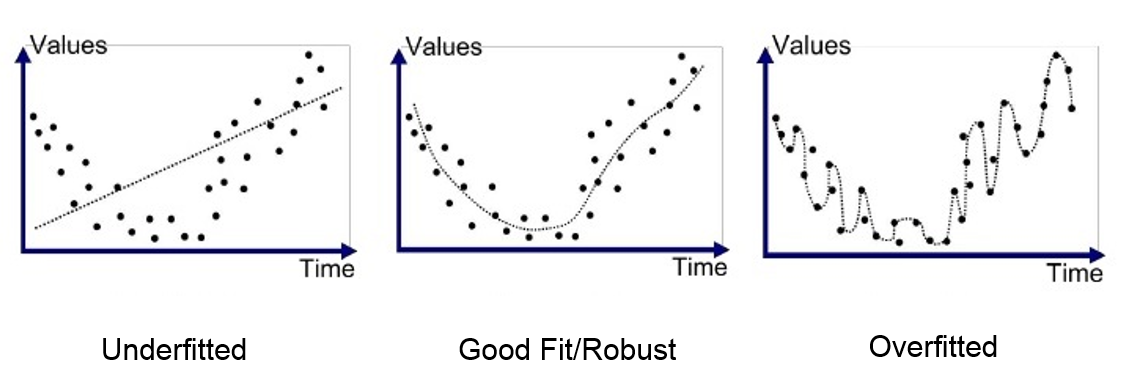

Um dos sinais mais comuns de overfitting é quando:

- A **loss do treino continua diminuindo** ao longo das épocas.
- A **loss de validação começa a aumentar** após certo ponto.


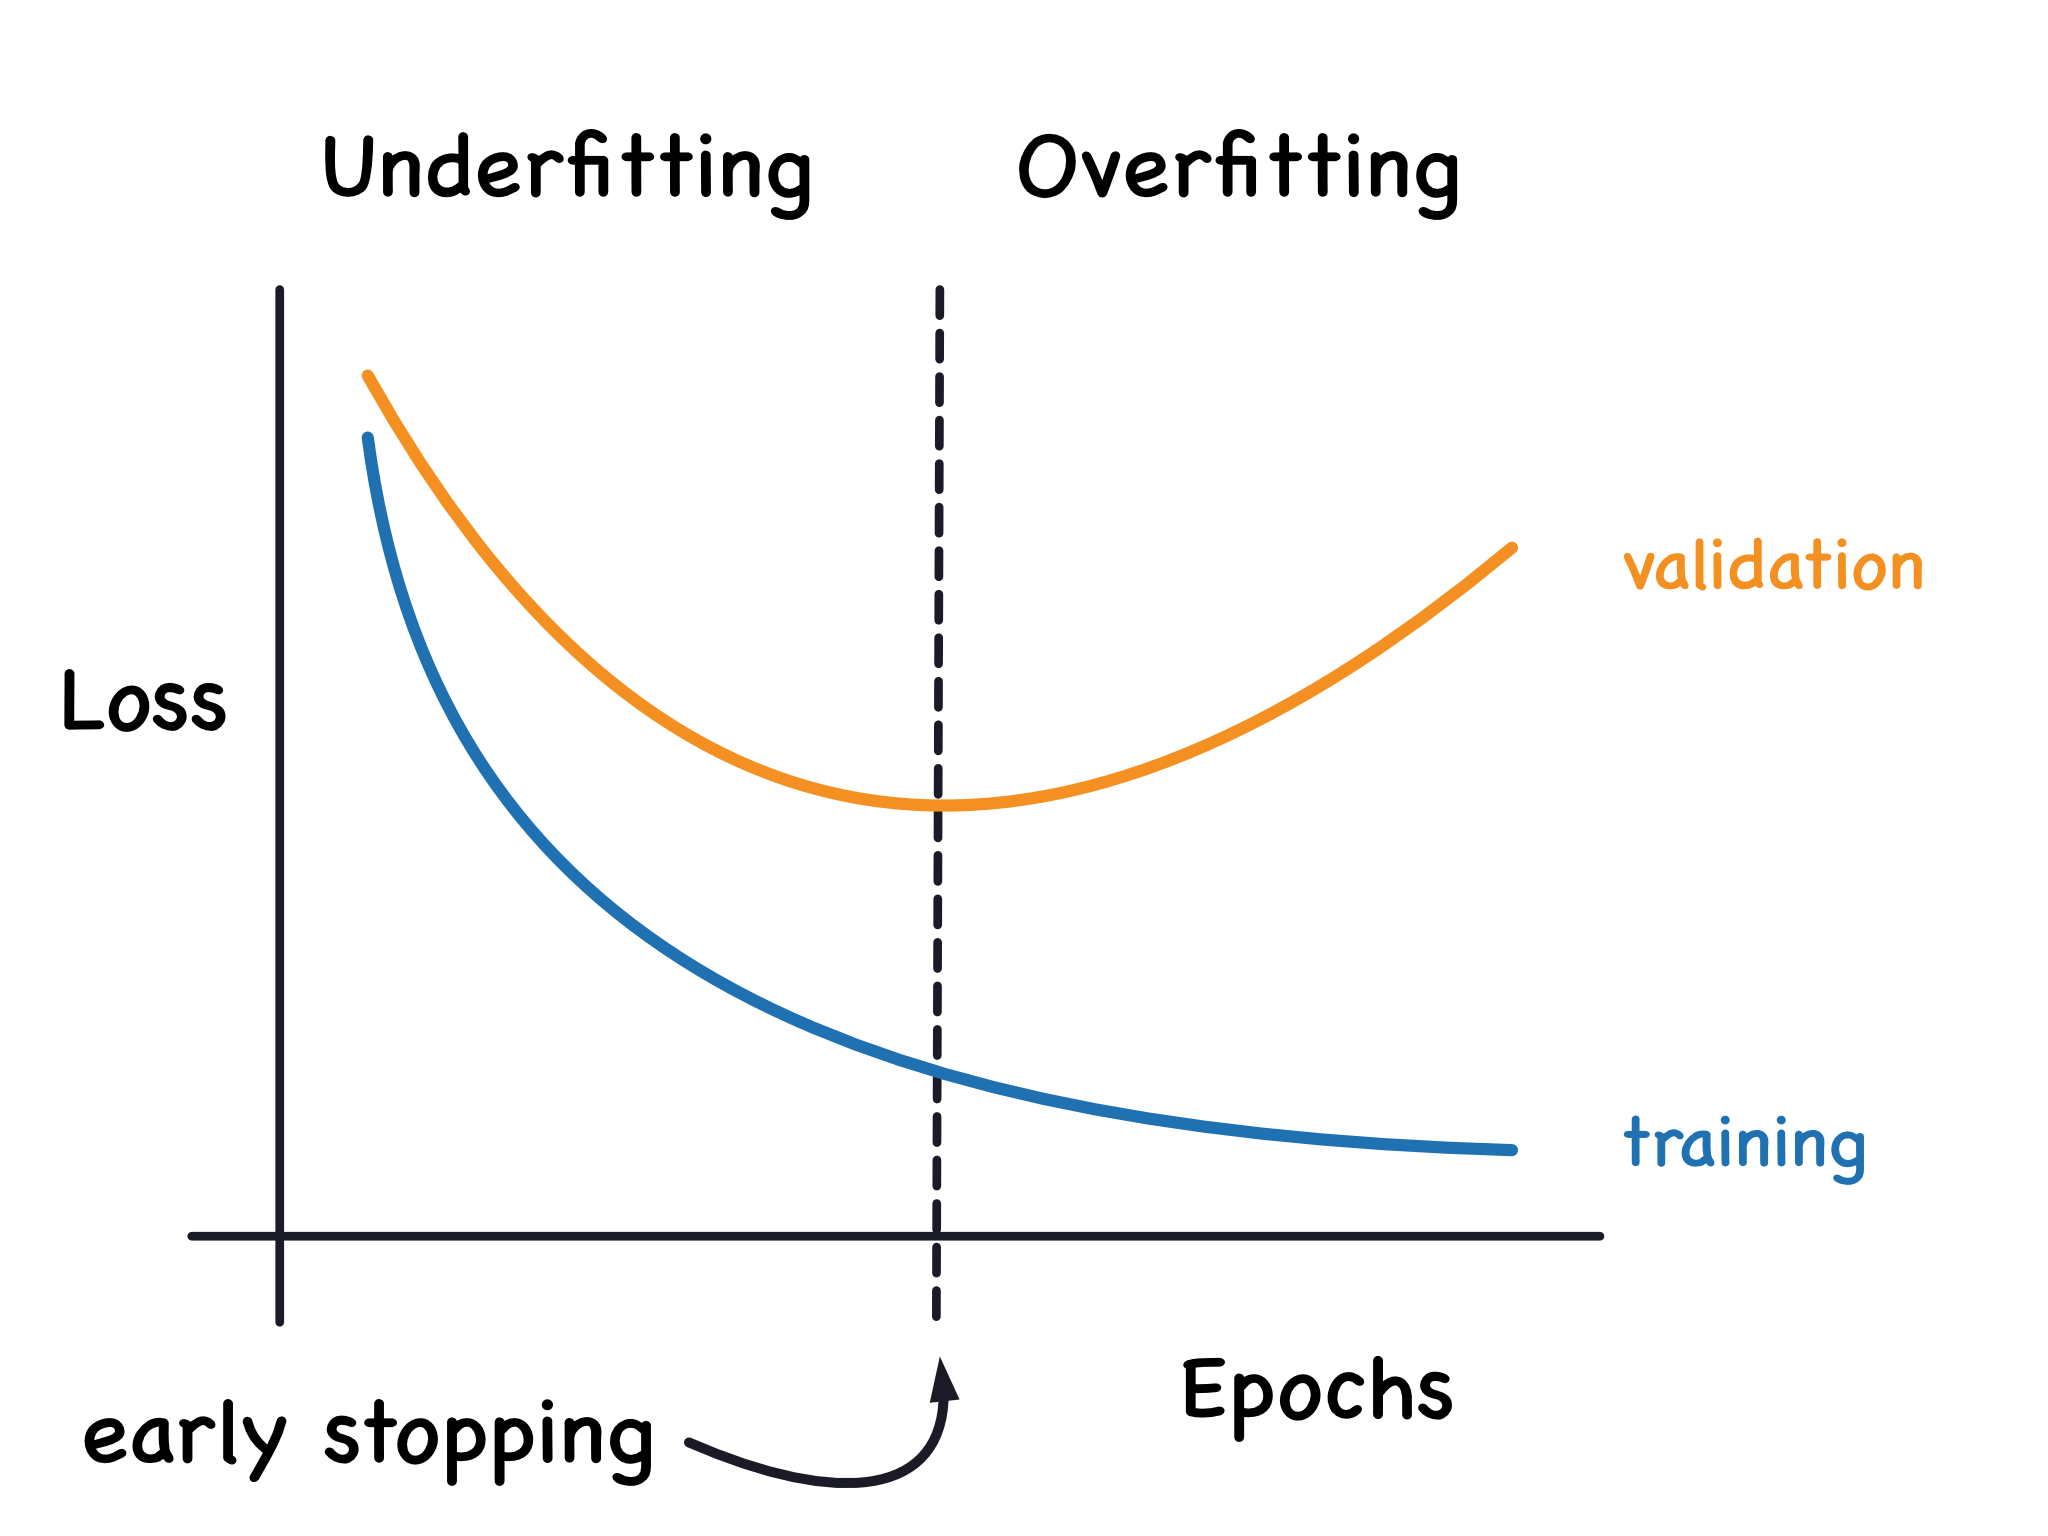

### Regularização


**Técnicas de Regularização** são métodos usados para minimizar a chance de overfitting. A ideia central da regularização é impor restrições ao modelo que induzam ele a aprender os padrões mais relevantes dos dados. A seguir, são descritas algumas técnicas.



#### L1 (Lasso) 

Adiciona a soma dos valores absolutos dos pesos à função objetivo passa a ser:

$$
Perda + \lambda \sum_{w_i \in w} |w_i|
$$

onde $w$ é o conjunto de parâmetros (pesos e biases) da rede, $|w_i|$ é o valor absoluto de $w_i$ e $\lambda$ é um hiperparâmetro que controla se queremos priorizar a redução dos valores dos parâmetros ou da função de perda. 

Note que:

* Para $w_i > 0$, a derivada de $|w|$ é +1
* Para $w_i < 0$, a derivada é -1
* Para $w_i = 0$, assumimos derivada igual a 0 programaticamente.

Ao minimizar a função de perda, o termo de regularização inclui uma derivada em $w_i$ que será **constante** ($\pm \lambda$), independente do valor de $w_i$. Isto é, independente do valor ser pequeno ou grande, ele será incentivado da mesma forma a se aproximar de zero. Como assumimos derivada 0 no ponto zero, o parâmetro para de mudar ao chegar ali. 

Assim, esta forma de regularização, tende a produzir modelos esparsos (com muitos coeficientes iguais a zero), o que também serve para seleção de variáveis. 




#### L2 (Ridge)

Adiciona a soma dos quadrados dos pesos à função objetivo que passa a ser: 

$$
Perda + \lambda \sum_{w_i \in w} w_i^2
$$

Diferente do caso anterior, a derivada do termo de regularização em relação a $w_i$ é $2 \lambda w_i$. Este termo se torna menor quando $w_i$ tende a zero. Como resultado, o incentivo para $w_i$ ir para zero se reduz à medida que o parâmetro se aproxima deste valor. Como resultado, esta forma de regularização tende a manter todos os coeficientes, mas reduz sua magnitude. 




#### Early stopping

Monitora o desempenho em um conjunto de validação e interrompe o treinamento assim que o desempenho começar a piorar, prevenindo o sobreajuste.




#### Dropout

Durante o treino, "desliga" aleatoriamente algumas unidades (neurônios) da rede em cada iteração. Temporariamente, a rede passa a ter menos parâmetros ajustáveis. 

Isto evita que a rede dependa demais de partes específicas ou padrões específicos da entrada o que é uma característica de modelos superajustados (e.g., uma classe receber alta probabilidade quando um pixel específico tem uma determinada cor). 

Além disso, o dropout funciona como mecanimos de regularização por prevenir que a rede se comporte como um *ensemble de sub-redes*. 

- Um *ensemble* é uma técnica em que vários modelos são utilizados para resolver uma tarefa. É como se ao invés de ter um profissional especialista, você contratasse um time de especialistas e eles, em conjunto, realizassem a tomada de decisão. 
  - Um conjunto de modelos fracos (com performance minimamente superior à uma escolha aleatória) podem ser unidos em um modelo forte.
  - Técnicas relacionadas: bagging, average summarization, voting summarization, boosting, etc.

- Durante o treinamento com dropout, sempre que uma amostra é treinada, alguns neurônios e/ou partes da entrada são escolhidos para serem desligados. Isto é análogo a treinar um modelo mais simples (a sub-rede ativa) usando parte do dataset (a amostra sendo treinada). No longo prazo, é como se estivéssemos fazendo bagging com redes menores, exceto que existe compartilhamento de pesos entre as redes. 

- Após o treinamento, a rede completa é ativada e as "sub-redes" passam a atuar em conjunto. Idealmente, a saída da rede passa a ter o comportamento similar ao de um *ensemble* e demonstrar mais suavidade do que seria esperado para uma rede com a mesma quantidade de parâmetros e treinada sem dropout. 

- Contudo, como a rede foi treinada sempre com apenas parte dos neurônios ativa, ao ativar todos os neurônios o comportamento pode ser diferente. Por exemplo, se $50\%$ dos neurônios estavam ativos durante o treinamento, é possível que ativando todos os neurônios, a saída dobre de valor. Para compensar este fato, após o treinamento, ações são realizadas para compensar este fato como multiplicar os parâmetros pela taxa de dropout (0.5, no exemplo). 
  

### Calibração de Hiperparâmetros e Conjuntos de Validação


- **Conjunto de Treino**: usado para ajustar os parâmetros do modelo (pesos da rede, por exemplo). Durante o treinamento, o modelo "aprende" a partir dos exemplos presentes nesse conjunto.
- **Conjunto de Validação**: usado para monitorar o desempenho do modelo em dados não vistos durante o treino. Ele não influencia diretamente os pesos, mas serve como base para decisões sobre o treinamento, como ajuste de hiperparâmetros e detecção de overfitting.
- **Conjunto de Teste**: usado **apenas no final**, para avaliar a performance final do modelo. Ele fornece uma estimativa imparcial da capacidade de generalização do modelo.

O conjunto de validação é utilizado principalmente para:

- Avaliar se o modelo está **overfitting** ao conjunto de treino.
- Monitorar métricas de desempenho (ex: acurácia, loss) durante o treinamento.
- **Ajustar hiperparâmetros**, como taxa de aprendizado, número de camadas, regularização etc.
- Implementar **early stopping**, interrompendo o treinamento quando a performance no conjunto de validação começa a piorar.

Dentre os hiperparâmetros que podemos calibrar usando o conjunto de validação, podemos citar:

- Número de neurônios e de camadas
- Tipo de função de ativação
- Taxa de aprendizado
- Técnicas de regularização (L2, dropout)
- Tamanho de batch

Ao medir o desempenho em validação para cada combinação, podemos usar métodos como:

- **grid search**,
- **random search** ou 
- **otimização bayesiana**.



### Stochastic Gradient Descent 

Vimos que o algoritmo de descida do gradiente (*gradient descent*) pode ser usado para resolver problemas de otimização em que a função objetivo é diferenciável. 

O **Stochastic Gradient Descent (SGD)** é uma técnica que atualiza os pesos com base em **exemplos únicos** ou **pequenos grupos (mini-batches)** ao invés de calcular o gradiente total do erro considerando **todos** os exemplos.

- **Mini-batches** são subconjuntos aleatórios dos dados de treino.
- Cada mini-batch é usado para computar um gradiente e realizar uma atualização dos pesos.
- O uso de mini-batches oferece um bom equilíbrio entre **estabilidade** e **eficiência**.


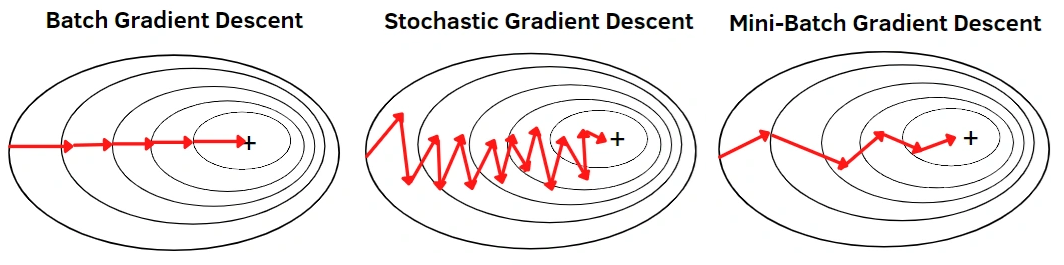

#### Por que não acumular o gradiente uma época inteira?

1. **Convergência Mais Rápida por Época**: Apesar de menos preciso, o SGD costuma convergir mais rapidamente porque realiza mais atualizações por época.

1. **Ver progresso e identificar problemas rápido**: Com atualizações mais frequentes, é possível ver o desempenho, as taxas de melhoria e problemas do seu modelo mais rapidamente. Além disso, o modelo começa a melhorar imediatamente e continuamente, ao invés de esperar até o fim da época para fazer atualizações.

1. **Melhor Generalização (devido ao ruído) e Escapar de Mínimos Locais**: A aleatoriedade dos batches adiciona "ruído" ao processo de otimização. Esse ruído pode ajudar o modelo a escapar de mínimos locais e saddle points. Ele pode contribuir ainda para produção de um modelo mais geral.




### Cross-Entropy Loss


A função de perda por **entropia cruzada (Cross-Entropy Loss)** mede a diferença entre a distribuição real (rótulo verdadeiro) e a distribuição prevista pelo modelo.

É baseada no conceito de entropia da teoria da informação de Shannon, que mede o grau de incerteza em uma distribuição.



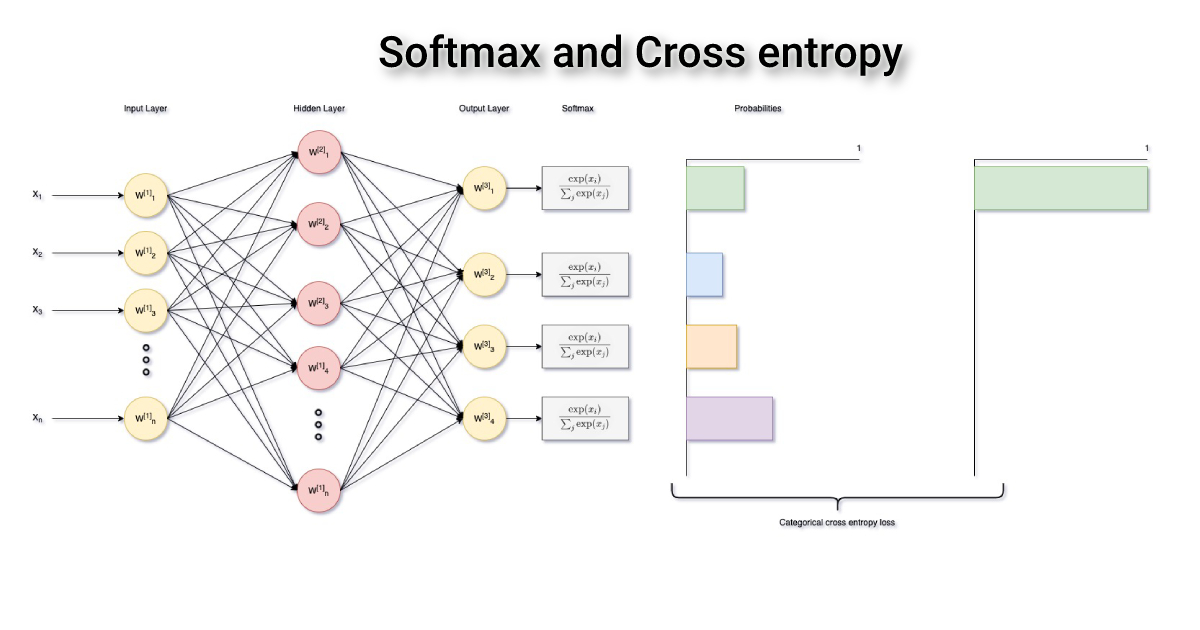

#### Representação de Classes usando Vetores One-Hot

Na representação **one-hot**, a classe de uma amostra é representada por um array do mesmo tamanho do número de classes. Neste array, a posição $i$ é 1 se a classe correta é $i$ e 0 caso contrário. Por exemplo:

- 3 classes e a correta é 0: $[1, 0, 0]$.
- 3 classes e a correta é 1: $[0, 1, 0]$.
- 3 classes e a correta é 2: $[0, 0, 1]$.
- 5 classes e a correta é 3: $[0, 0, 0, 1, 0]$.

#### Fórmula da Entropia Cruzada

Considere um problema de classificação em que a saída do modelo é um vetor de probabilidades por classe. Seja $y^{pred}$ a saída do modelo e $y^{true}$ a resposta correta (label) em representação **one-hot**. A entropia cruzada é dada por:

$$
\text{CrossEntropy}(y^{true}, y^{pred}) = -\sum_{i=1}^C y_i^{true} \log(y_i^{pred})
$$

onde:
- $ y^{true}_i $ é 1 se a classe correta é $ i $, 0 caso contrário (one-hot).
- $ y^{pred}_i $ é a probabilidade predita para a classe $ i $.

Portanto, para um único exemplo com classe correta $ c $:

$$
\text{Loss} = -\log(y^{pred}_c)
$$



#### Cálculo do Gradiente

Se a função de ativação da última camada é **softmax**:

$$
y^{pred}_i = \frac{e^{z_i}}{\sum_j e^{z_j}}
$$

E usamos entropia cruzada como perda, a derivada da loss em relação à entrada $ z_i $ da softmax é:

$$
\frac{\partial \text{Loss}}{\partial z_i} = y^{pred}_i - y^{true}_i
$$

Esse resultado elegante vem da derivada combinada da softmax com a cross-entropy. Veja [este link](https://shivammehta25.github.io/posts/deriving-categorical-cross-entropy-and-softmax/) para saber mais sobre a derivação matemática do gradiente.


## Uso do Pytorch

Pytorch é um dentre vários frameworks e bibliotecas para implementação de redes neurais. 

Outras ferramentas importantes são: 
- **Tensorflow**: Alternativa ao pytorch. Possui boas ferramentas de deploy e um wrapper em javascript. Utilizada grafos estáticos (definidos a priori) no passado. 
- **Huggingface (transformers)**: Framework especializado em arquiteturas baseadas em transformers. Possui um repositório de modelos pré-treinados.
- **JAX**: Biblioteca mais de baixo nível à lá numpy com diferenciação automática.
- **Keras**: Biblioteca de alto nível que permite utiliza outros frameworks como "backend". 
- **Lightning**: Biblioteca de alto nível construída sobre o pytorch para reduzir o número de linhas necessárias para treinar um modelo.
  

### Visão de Alto Nível

Como indicado na figura abaixo, para treinar um modelo usando Pytorch, precisamos: 
1. Um dataset no formato esperado pelo framework.
2. Um dataloder para carregar dados eficientemente, organizar dados em batches, etc.
3. Um modelo a ser treinado
4. Um otimizador para ajustar os pesos 
5. Um loop de treinamento 
6. Métricas e visualizações de avaliação

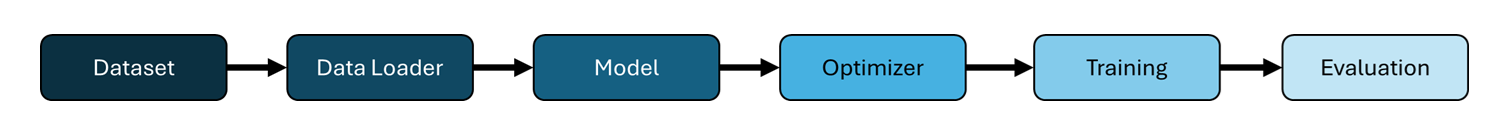

### Dataset

São dados usados no treinamento e teste do modelo. É definido criando uma subclasse de `torch.utils.data.Dataset` e implementando os métodos: 
- `__len__`: Retorna o número de amostras do dataset.
- `__getitem__`: Retorna uma amostra do dataset. No caso de aprendizado supervisionado, retorna um par `(entrada, saída)`. 

Para exemplificar, vamos criar um `Dataset` para representar os dados da base MNIST.

O trecho abaixo faz o download da base de dados e normaliza os valores dos pixels para o intervalo $[-1, 1]$. Em seguida, os dados são divididos em conjuntos de treinamento, validação e teste.

In [3]:

# fazer o download da base MNIST
mnist = fetch_openml('mnist_784', as_frame=False, cache=False)
mnist_X = mnist.data.astype('float32')
mnist_y = mnist.target.astype('int64')

# normaliza os dados para [-1, 1]
mnist_X /= 255.0
mnist_X = mnist_X * 2 - 1


In [18]:

# Separa conjuntos de treinamento (50.000), validação (10.000) e teste (10.000)
train_x = mnist_X[:50000]
train_y = mnist_y[:50000]
val_x = mnist_X[50000:60000]
val_y = mnist_y[50000:60000]
test_x = mnist_X[60000:70000]
test_y = mnist_y[60000:70000]

print("train shape:", train_x.shape, train_y.shape)
print("val shape:", val_x.shape, val_y.shape)
print("test shape:", test_x.shape, test_y.shape)

train shape: (50000, 784) (50000,)
val shape: (10000, 784) (10000,)
test shape: (10000, 784) (10000,)


In [19]:

class MnistDataset(Dataset):
    def __init__(self, x, y):
        self._x = x
        self._y = y

    def __len__(self):
        return len(self._x)

    def __getitem__(self, idx):
        img = self._x[idx]
        label = self._y[idx]
        img = torch.from_numpy(img)
        return img, label

train_dataset = MnistDataset(train_x, train_y)
val_dataset = MnistDataset(val_x, val_y)
test_dataset = MnistDataset(test_x, test_y)

img, label = train_dataset[0]
img

tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.00

### Data Loader

batch shape: torch.Size([64, 784])
Min: tensor(-1.) Max: tensor(1.)
Labels: tensor([5, 8, 2, 8, 0, 1, 4, 3, 7, 3, 1, 3, 2, 0, 8, 6, 0, 7, 7, 7, 6, 9, 4, 0,
        8, 2, 1, 3, 2, 2, 8, 8, 0, 9, 8, 0, 6, 5, 8, 9, 3, 6, 6, 3, 8, 5, 0, 7,
        8, 9, 3, 9, 2, 0, 5, 6, 5, 5, 6, 4, 8, 6, 4, 1])
Labels shape: torch.Size([64])


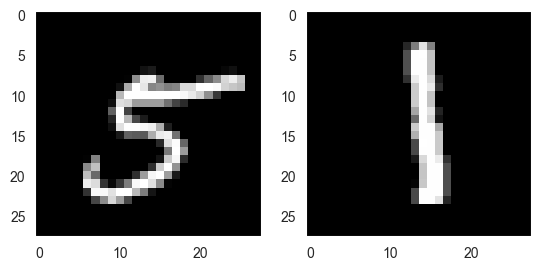

In [20]:

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


# Mostra alguns exemplos
imgs, labels = next(iter(train_loader))

plt.subplot(1, 2, 1)
plt.imshow(imgs[0].reshape((28, 28)), cmap='gray')
plt.grid(False)
plt.subplot(1, 2, 2)
plt.imshow(imgs[-1].reshape((28, 28)), cmap='gray')
plt.grid(False)

# Mostra o shape e os valores minimo e máximo de um batch
print("batch shape:", imgs.shape)
print("Min:", imgs.min(), "Max:", imgs.max())
print("Labels:", labels)
print("Labels shape:", labels.shape)


### Modelo

In [21]:

class MnistNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        y = self.fc3(h2)
        return y

net = MnistNet()
net



MnistNet(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)

### Treinamento

epoch 0 train loss: 1.7040027540815457 val loss: 0.88670440426298
epoch 1 train loss: 0.657990625104331 val loss: 0.4653930390716358
epoch 2 train loss: 0.4548163038423604 val loss: 0.3837227033107144
epoch 3 train loss: 0.39281797125135237 val loss: 0.3384175487099939
epoch 4 train loss: 0.36132621599356535 val loss: 0.32334733590673487
epoch 5 train loss: 0.34118116440256235 val loss: 0.3028684559568858
epoch 6 train loss: 0.3262329461419826 val loss: 0.290965349763442
epoch 7 train loss: 0.3144180742390168 val loss: 0.290980874803985
epoch 8 train loss: 0.30400142535719726 val loss: 0.27334182400991963
epoch 9 train loss: 0.29496945267366936 val loss: 0.26788013478278355
epoch 10 train loss: 0.2873912803600054 val loss: 0.26524182647514116
epoch 11 train loss: 0.28010627415860095 val loss: 0.2557163901959255
epoch 12 train loss: 0.27262829650012427 val loss: 0.24906358297226155
epoch 13 train loss: 0.2656310352561114 val loss: 0.24856881584948415
epoch 14 train loss: 0.2596266551986

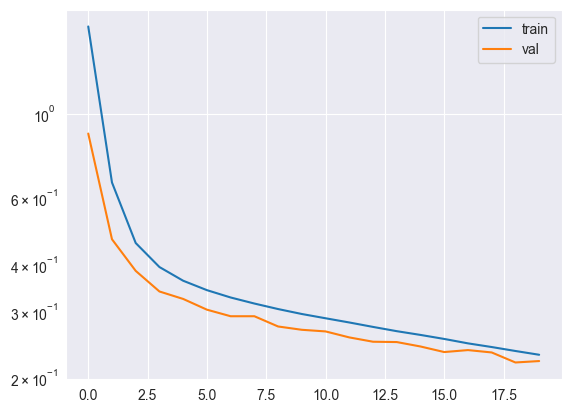

In [22]:

# instanciacao do modelo
net = MnistNet()

# funcao de perda
criterion = nn.CrossEntropyLoss()

# otimizador
optimizer = optim.SGD(net.parameters(), lr=5e-3)

# listas para armazenar os valores da loss para treino e validacao
train_history = []
val_history = []

# repete por um número de épocas
for epoch in range(20):
    epoch_loss = []

    # itera sobre batches de dados
    for i, data in enumerate(train_loader):
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # adiciona o erro de treinamento do batch
        epoch_loss.append(loss.item())

    # calcula o erro de validacao
    val_loss = []
    # itera sobre os batches de validacao
    for i, data in enumerate(val_loader):
        inputs, labels = data
        # nao armazena os dados necessarios para computar gradientes
        with torch.no_grad():
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss.append(loss.item())

    epoch_loss = np.mean(epoch_loss)
    val_loss = np.mean(val_loss)

    print(f"epoch {epoch} train loss: {epoch_loss} val loss: {val_loss}")
    train_history.append(epoch_loss)
    val_history.append(val_loss)

print('Finished Training')

plt.plot(train_history, label='train')
plt.plot(val_history, label='val')
plt.yscale('log')
plt.legend()

### Avaliação

In [23]:
pred = np.array([])
true = np.array([])

for batch in test_loader:
    imgs, labels = batch
    unorm_probs = net(imgs)
    true = np.append(true, labels)
    pred = np.append(pred, unorm_probs.detach().numpy().argmax(axis=-1))

print(true.shape)
print(pred.shape)

(10000,)
(10000,)


In [24]:
print(classification_report(true, pred))

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96       980
         1.0       0.95      0.98      0.97      1135
         2.0       0.93      0.93      0.93      1032
         3.0       0.92      0.92      0.92      1010
         4.0       0.93      0.94      0.93       982
         5.0       0.92      0.88      0.90       892
         6.0       0.92      0.97      0.94       958
         7.0       0.95      0.93      0.94      1028
         8.0       0.89      0.91      0.90       974
         9.0       0.95      0.90      0.92      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



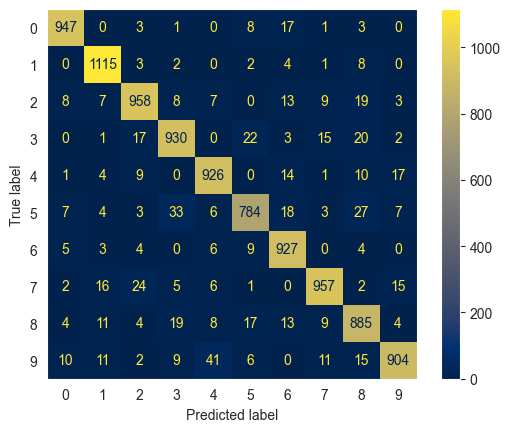

In [25]:

cm = confusion_matrix(true, pred, labels=list(range(10)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
disp.plot(cmap='cividis')
plt.grid(False)
plt.show()


Mostra alguns casos em que a rede errou a classificação:

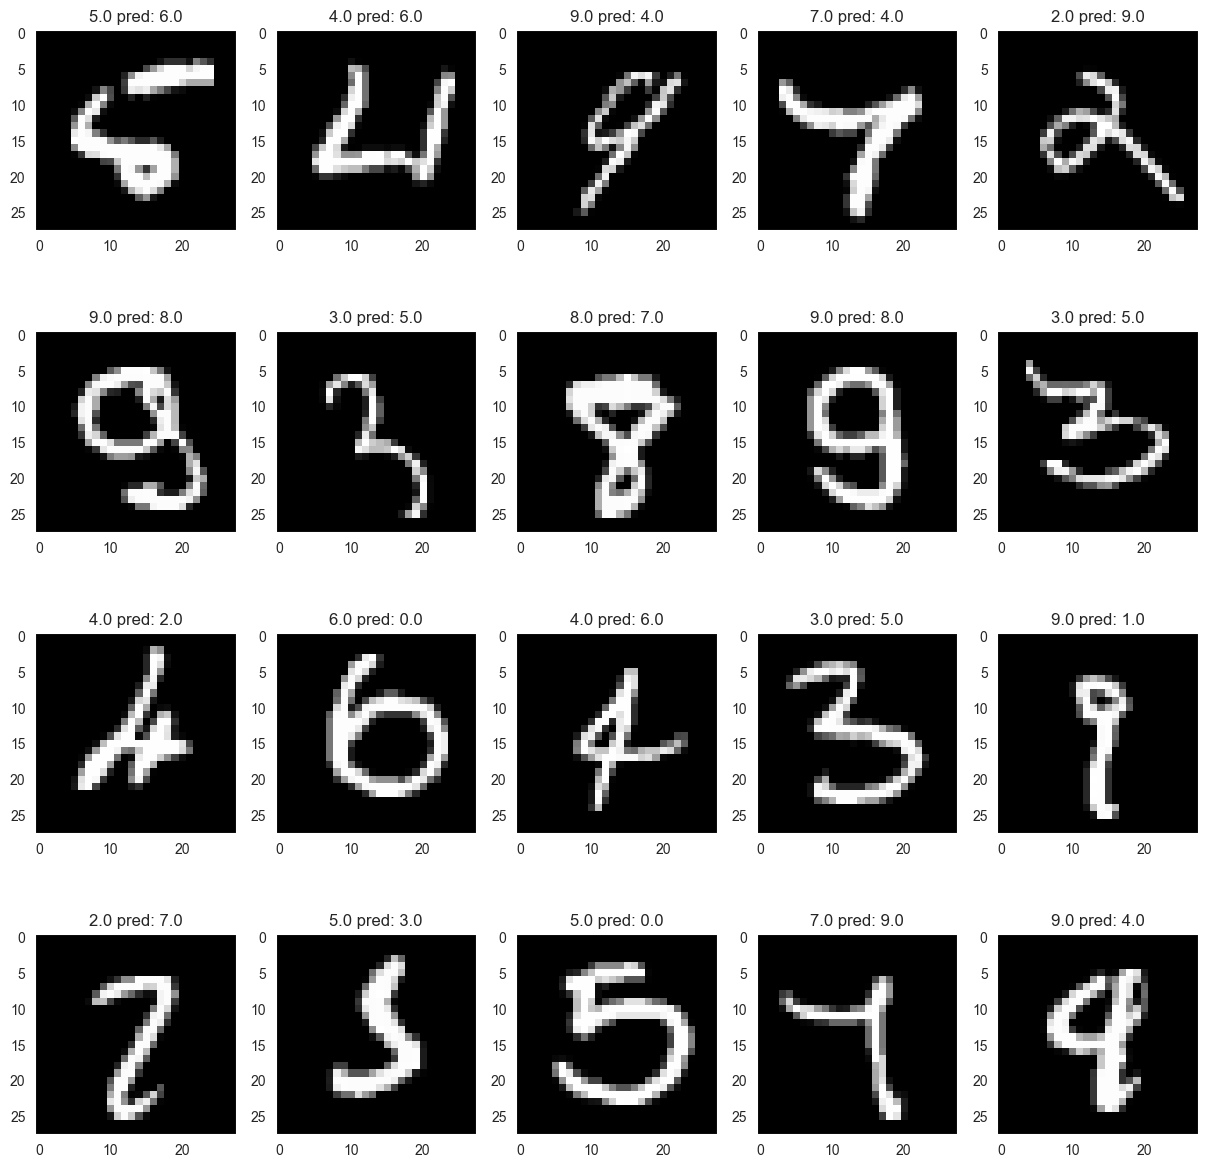

In [26]:
mistakes = [idx for idx in range(pred.shape[0]) if pred[idx] != true[idx]]

plt.figure(figsize=(15, 15))
for item_id, sample_idx in enumerate(mistakes[:20]):
    plt.subplot(4, 5, item_id + 1)
    plt.imshow(test_x[sample_idx].reshape((28, 28)), cmap='gray')
    plt.grid(False)
    plt.title(f"{true[sample_idx]} pred: {pred[sample_idx]}")


## Exemplo de Regressão

Gera dados de treinamento, validação e teste:

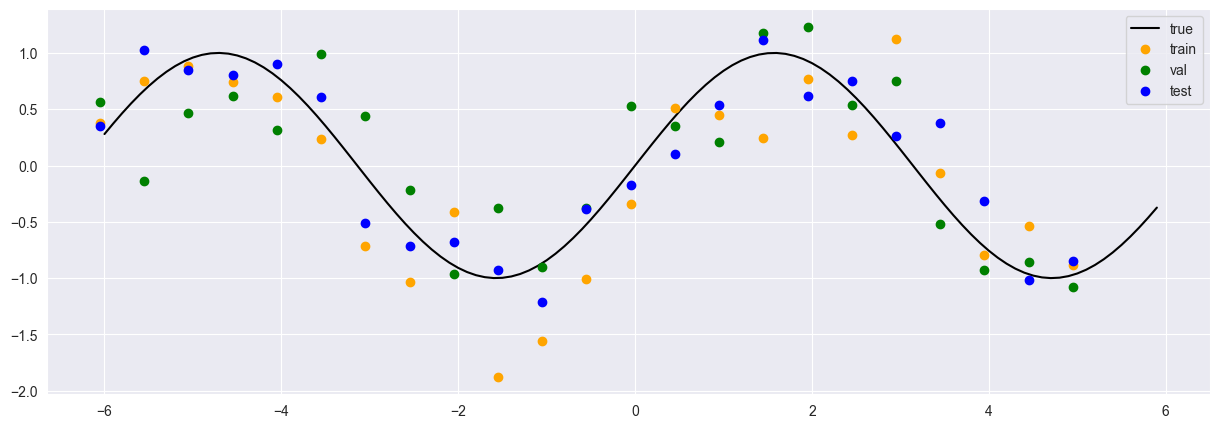

In [32]:
all_x = np.arange(-6.0, 6.0, 0.1)
val_x = test_x = train_x = np.arange(-6.05, 5.06, 0.5)

all_y = np.sin(all_x)
train_y = np.sin(train_x) + np.random.normal(size=train_x.shape) * 0.4
val_y = np.sin(test_x) + np.random.normal(size=test_x.shape) * 0.4
test_y = np.sin(test_x) + np.random.normal(size=test_x.shape) * 0.4

plt.close('all')
plt.figure(figsize=(15,5))
plt.plot(all_x, all_y, '-', color='black', label='true')
plt.plot(train_x, train_y, 'o', color='orange', label='train')
plt.plot(val_x, val_y, 'o', color='green', label='val')
plt.plot(test_x, test_y, 'o', color='blue', label='test')
plt.legend()
plt.show()


In [33]:

class RegDataset(Dataset):
    def __init__(self, x, y):
        self._x = torch.from_numpy(x.astype(np.float32).reshape((x.shape[0], 1)))
        self._y = torch.from_numpy(y.astype(np.float32).reshape((y.shape[0], 1)))

    def __len__(self):
        return len(self._x)

    def __getitem__(self, idx):
        return self._x[idx], self._y[idx]

train_dataset = RegDataset(train_x, train_y)
val_dataset = RegDataset(val_x, val_y)
test_dataset = RegDataset(test_x, test_y)

train_dataset[0]

(tensor([-6.0500]), tensor([0.3775]))

In [34]:

batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [50]:

class RegressionNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        h1 = F.tanh(self.fc1(x))
        h2 = F.tanh(self.fc2(h1))
        y = self.fc3(h2)
        return y

net = RegressionNet()
net



RegressionNet(
  (fc1): Linear(in_features=1, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

epoch 0 train loss: 0.6842733522256216 val loss: 0.4937076270580292
epoch 100 train loss: 0.16088338444630304 val loss: 0.307272732257843
epoch 200 train loss: 0.18794190883636475 val loss: 0.35062440236409503
epoch 300 train loss: 0.14271233975887299 val loss: 0.3199746658404668
epoch 400 train loss: 0.13471927493810654 val loss: 0.3054801672697067
epoch 500 train loss: 0.15122238794962564 val loss: 0.3286220928033193
epoch 600 train loss: 0.1343712272743384 val loss: 0.348900372783343
epoch 700 train loss: 0.12633593380451202 val loss: 0.32055537899335224
epoch 800 train loss: 0.13746543725331625 val loss: 0.32250340779622394
epoch 900 train loss: 0.12929536402225494 val loss: 0.29709938665231067
epoch 1000 train loss: 0.12540932496388754 val loss: 0.3161079337199529
epoch 1100 train loss: 0.13023970276117325 val loss: 0.31014057000478107
epoch 1200 train loss: 0.13610305885473886 val loss: 0.2754063755273819
epoch 1300 train loss: 0.1116271788875262 val loss: 0.28552080194155377
epo

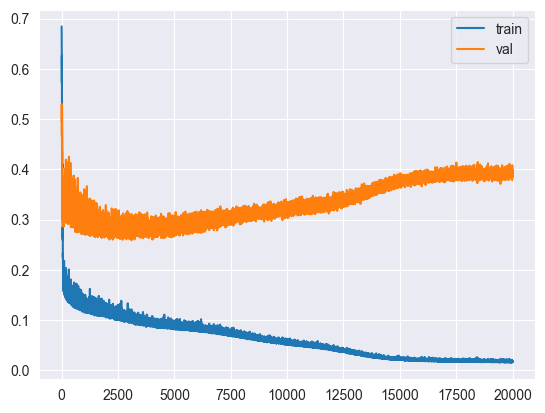

In [52]:

# instanciacao do modelo
net = RegressionNet()

# funcao de perda
criterion = nn.MSELoss()

# otimizador
optimizer = optim.SGD(net.parameters(), lr=1e-2)

# listas para armazenar os valores da loss para treino e validacao
train_history = []
val_history = []

# repete por um número de épocas
for epoch in range(20000):
    epoch_loss = []

    # itera sobre batches de dados
    for i, data in enumerate(train_loader):
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # adiciona o erro de treinamento do batch
        epoch_loss.append(loss.item())

    # calcula o erro de validacao
    val_loss = []
    # itera sobre os batches de validacao
    for i, data in enumerate(val_loader):
        inputs, labels = data
        # nao armazena os dados necessarios para computar gradientes
        with torch.no_grad():
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss.append(loss.item())

    epoch_loss = np.mean(epoch_loss)
    val_loss = np.mean(val_loss)

    if epoch % 100 == 0:
        print(f"epoch {epoch} train loss: {epoch_loss} val loss: {val_loss}")

    train_history.append(epoch_loss)
    val_history.append(val_loss)

print('Finished Training')

plt.plot(train_history, label='train')
plt.plot(val_history, label='val')
plt.legend()

Erro no conjunto de teste:

In [53]:

test_loss = []

with torch.no_grad():
    for (x_i, y_i) in test_loader:
        outputs = net(x_i)
        loss = criterion(outputs, y_i)
        test_loss.append(loss.item())

np.mean(test_loss)

np.float64(0.16950872043768564)

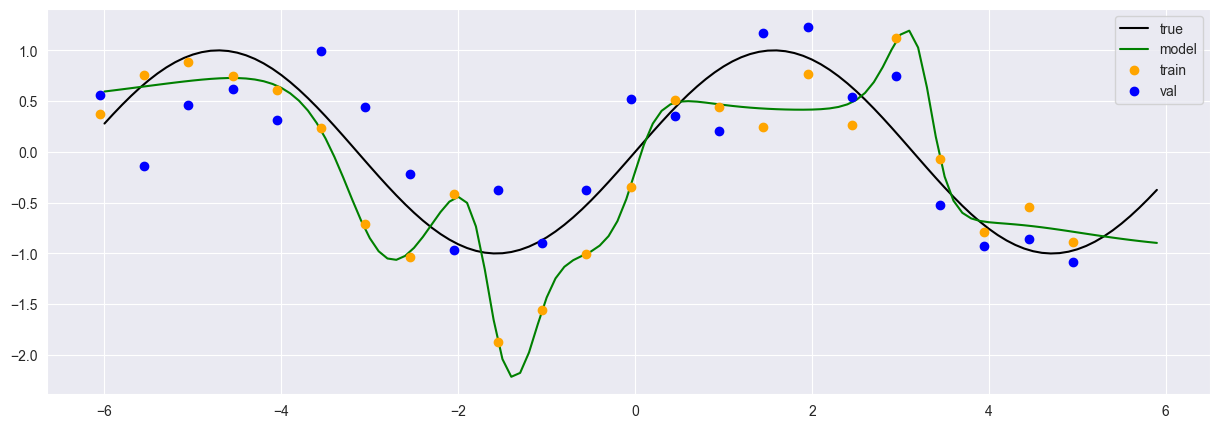

In [54]:

preds = np.array([])

with torch.no_grad():
    for x_i in all_x:
        y_i = net(torch.from_numpy(np.array([x_i], dtype=np.float32)))
        preds = np.append(preds, y_i[0])


plt.close('all')
plt.figure(figsize=(15,5))
plt.plot(all_x, all_y, '-', color='black', label='true')
plt.plot(all_x, preds, '-', color='green', label='model')
plt.plot(train_x, train_y, 'o', color='orange', label='train')
plt.plot(val_x, val_y, 'o', color='blue', label='val')
plt.legend()
plt.show()


**Atividade:** Tente ajustar os hiperparâmetros e utilizar as técnicas de regularização para melhorar o ajuste na tarefa.